In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import math

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
print(f'Device is: {device}')

!nvidia-smi

Device is: cuda
Wed Mar 10 19:10:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                        

Make data

(500, 8, 24, 1)
(500, 24, 1)


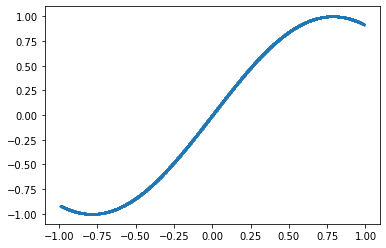

In [3]:
# Data set has to have shape N_batches x seq_len x batch_size x N_in
batch_size = 24
N_batches = 500
seq_len = 8
N_in = 1

x = np.array([[[[i + j + k + 2*n for i in range(N_in)] for j in range(batch_size)] for k in range(seq_len)] for n in range(N_batches)])
print(x.shape)

x = 2 * (x - np.mean(x))/np.max(x)

#y = np.mean(x, axis=1) * np.mean(x, axis=1)
y = np.sin(2*np.mean(x, axis=1))
print(y.shape)

plt.scatter(np.mean(x, axis=1).flatten(), y.flatten(), s = 1)

In [4]:
#Shuffle data
np.random.seed(0)
torch.manual_seed(0)

X_ordered = x
y_ordered = y
inds = np.random.permutation(np.arange(N_batches))
X = X_ordered[inds]
y = y_ordered[inds]

In [5]:
#Split data
N_train = int(0.8 * N_batches)

X_train = X[:N_train]
y_train = y[:N_train]
X_train = torch.from_numpy(X_train).double().to(device)
y_train = torch.from_numpy(y_train).double().to(device)

print("Train X and y")
print(X_train.shape, y_train.shape)

#Set test data set
X_test = X[N_train:]
y_test = y[N_train:]
X_test = torch.from_numpy(X_test).double().to(device)
y_test = torch.from_numpy(y_test).double().to(device)


print("Test X and y")
print(X_test.shape, y_test.shape)

Train X and y
torch.Size([400, 8, 24, 1]) torch.Size([400, 24, 1])
Test X and y
torch.Size([100, 8, 24, 1]) torch.Size([100, 24, 1])


In [6]:
#LSTM on toy data
N_lay = 2
N_out = 1

#Init the net
net = torch.nn.LSTM(N_in, N_out, N_lay).double().to(device)
print(net)

LSTM(1, 1, num_layers=2)


0 0.1469472664408564 tensor(0.0133, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


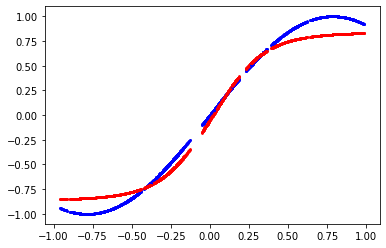

1 0.0059148331053720336 tensor(0.0032, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


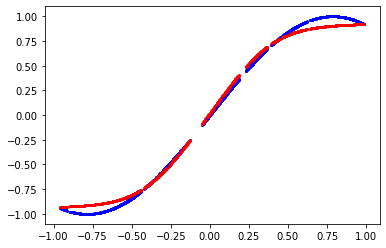

2 0.001948788864628773 tensor(0.0016, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


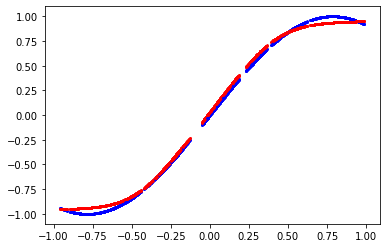

3 0.0009646944845924259 tensor(0.0009, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


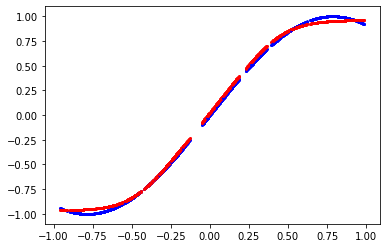

4 0.0006514021913993719 tensor(0.0005, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


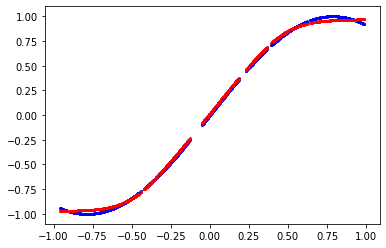

5 0.00046686394880348953 tensor(0.0004, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


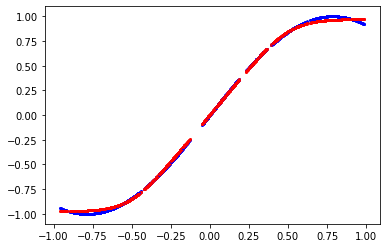

6 0.0003980132421227988 tensor(0.0004, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


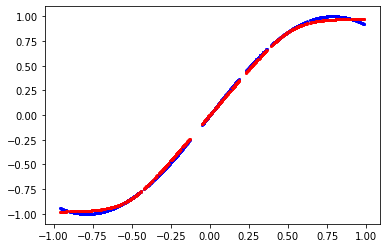

7 0.00040844525552604136 tensor(0.0004, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


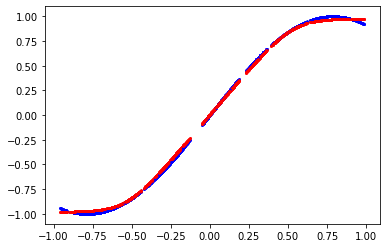

8 0.0004460498728092574 tensor(0.0004, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


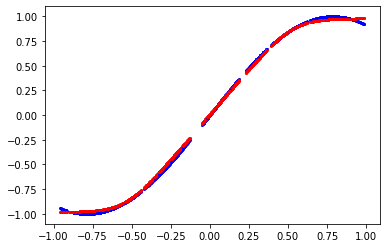

9 0.0004891436263293325 tensor(0.0003, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


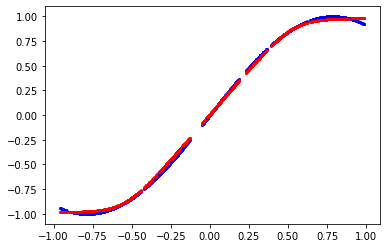

10 0.0005252175658815679 tensor(0.0003, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


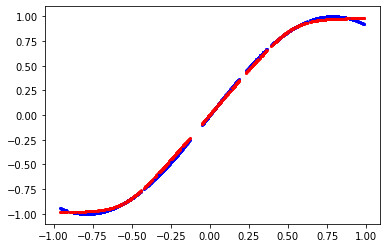

11 0.000535869797796069 tensor(0.0003, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


KeyboardInterrupt: ignored

In [7]:
#Train
optimizer = optim.Adam(net.parameters(), lr=1e-2)
Mloss = torch.nn.MSELoss()

N_epoch = 150

for epoch in range(N_epoch):
    loss_tracker = 0
    for i in range(X_train.shape[0]):
        optimizer.zero_grad()

        inp = X_train[i]
        target = y_train[i]

        output, _ = net(inp)
        pred = output[-1, :]
        loss = Mloss(pred, target)
        loss.backward()
 
        loss_tracker += loss.item()
        optimizer.step()
    
    #print(epoch, loss_tracker)

    # Test
    test_loss_tracker = 0
    for test in range(X_test.shape[0]):
      output, _ = net(X_test[test])
      preds = output[-1, :].clone().detach().cpu().numpy()
      targets = y_test[test].cpu().numpy()

      test_loss_tracker += Mloss(output[-1, :], y_test[test])
      
      xx = torch.mean(X_test[test], axis=0).cpu().numpy()
      plt.scatter(xx, targets, s = 3, color='blue')
      plt.scatter(xx, preds, s = 3, color='red')
      
    print(epoch, loss_tracker/X_train.shape[0], test_loss_tracker/X_test.shape[0])
    plt.show()

In [ ]:
# Test
test_loss_tracker = 0
for test in range(X_test.shape[0]):
  output, _ = net(X_test[test])
  preds = output[-1, :].clone().detach().cpu().numpy()
  targets = y_test[test].cpu().numpy()

  test_loss_tracker += Mloss(output[-1, :], y_test[test])
  
  xx = torch.mean(X_test[test], axis=0).cpu().numpy()
  plt.scatter(xx, targets, s = 3, color='blue')
  plt.scatter(xx, preds, s = 3, color='red')
  
print("Test loss: ", test_loss_tracker)
plt.show()